In [ ]:
# !unzip "/content/drive/MyDrive/Securitydataset.zip" -d "/content/drive/MyDrive/"


In [8]:
!pip install -q git+https://github.com/Deci-AI/super-gradients.git@stable
!pip install -q roboflow
!pip install -q supervision

In [1]:
import os
HOME = ""
print(HOME)

In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'

d:\Akash\Codes\BTechProject\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from super_gradients.training import models

model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

In [4]:
LOCATION = "D:\Akash\Codes\BTechProject\Securitydataset"
print("location:", LOCATION)
CLASSES = ["Car", "Person", "Gun", "Package"]
print("classes:", CLASSES)

In [5]:
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 15
MAX_EPOCHS = 10
CHECKPOINT_DIR = f'{HOME}/ObjectDetectionCheckpoints'
EXPERIMENT_NAME =  "Security_Object_Detection"

In [6]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [7]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [32]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

Indexing dataset annotations:  96%|█████████▌| 304/316 [00:03<00:00, 77.87it/s] 

Indexing dataset annotations: 100%|██████████| 316/316 [00:03<00:00, 85.95it/s]


In [9]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [8]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

d:\Akash\Codes\BTechProject\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

In [ ]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

In [ ]:
!zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

Load trained model

In [8]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    # checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/RUN_20231203_131613_464705/average_model.pth"
    checkpoint_path="ObjectDetectionCheckpoints/Security_Object_Detection/RUN_20231203_131613_464705/average_model.pth"
).to(DEVICE)

Evaluate trained model

In [ ]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Inference with trained model

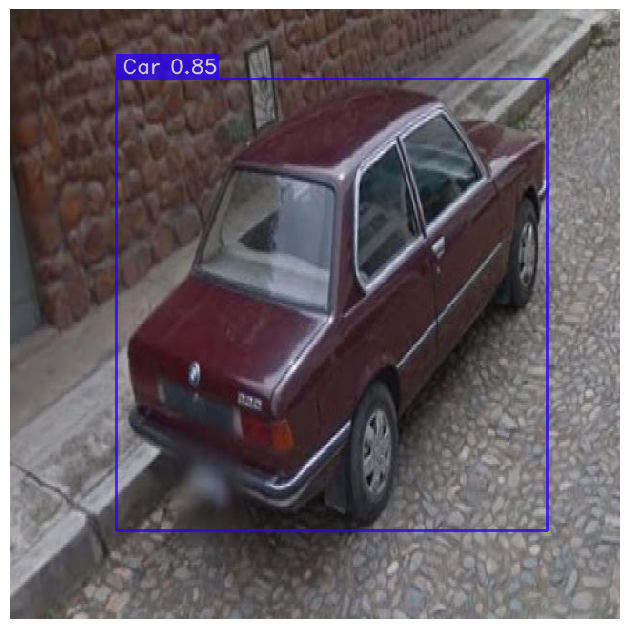

In [9]:
img_url = "Securitydataset/train/images/-1D1CDAD8-AB52-4C15-99E1-0F46C88FD2BB-png_jpg.rf.50e75dfc01e98ffd27a7b9823296bfde.jpg"
result = best_model.predict(img_url).show()
# result = list(best_model.predict(img_url, conf=0.5))[0]


In [15]:
import torch
best_model = best_model.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
best_model.predict_webcam()

In [10]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{LOCATION}/test/images",
    annotations_directory_path=f"{LOCATION}/test/labels",
    data_yaml_path=f"{LOCATION}/data.yaml",
    force_masks=False
)

In [ ]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

In [ ]:
import supervision as sv

detections = sv.Detections(
    xyxy=result.prediction.bboxes_xyxy,
    confidence=result.prediction.confidence,
    class_id=result.prediction.labels.astype(int)
)

box_annotator = sv.BoxAnnotator()

labels = [
    f"{result.class_names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (12, 12))

Visualize inference results


In [ ]:
import random
random.seed(10) 

In [ ]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))    

Calculate confusion matrix

In [11]:
!pip install onemetric

In [12]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)

NameError: name 'predictions' is not defined

In [1]:
# !pip install super-gradients
from super_gradients.training import models
import sys
sys.stdout = sys.__stdout__  # Resolve the error of models import
url = "https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg"
best_model = models.get("yolo_nas_l", pretrained_weights="coco")
# yolo_nas_l.predict(url, conf=0.25).show()

images_predictions = best_model.predict(url, conf=0.25)
# isDetection = False
for image_prediction in images_predictions:
    # isDetection = True
    bboxes = image_prediction.prediction.bboxes_xyxy
    class_ids=image_prediction.prediction.labels.astype(int)
    class_names_list = [image_prediction.class_names[cid] for cid in class_ids]
    object_locations = [(y1, x2, y2, x1) for x1, y1, x2, y2 in bboxes]
    print(f"Object Location: {len(object_locations)}, {len(class_names_list)}")

d:\Akash\Codes\BTechProject\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import cv2
import urllib.request
import numpy as np
# url = "https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg"
# Download the image from the URL
response = urllib.request.urlopen(url)
img_array = np.array(bytearray(response.read()), dtype=np.uint8)
frame = cv2.imdecode(img_array, -1)

for bbox, name in zip(object_locations, class_names_list):
    top, right, bottom, left = bbox
    cv2.rectangle(frame, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 3)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(frame, name, (int(left) + 6, int(bottom) - 6), font, 0.5, (255, 255, 255), 1)
cv2.imshow("Image with Rectangles", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
